## Lineáris és Polinomiális Regresszió a Tökárak Meghatározásához - 3. Lecke

Töltsd be a szükséges könyvtárakat és az adatállományt. Alakítsd át az adatokat egy adatkeretté, amely az adatok egy részhalmazát tartalmazza:

- Csak azokat a tököket válaszd ki, amelyeket bushel alapján áraznak
- Alakítsd át a dátumot hónappá
- Számítsd ki az árat a magas és alacsony árak átlagaként
- Alakítsd át az árat, hogy a bushel mennyiség szerinti árazást tükrözze


In [167]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

pumpkins = pd.read_csv('../../data/US-pumpkins.csv')
pumpkins.head()

City Name Type       Package      Variety Sub Variety  Grade     Date  \
0  BALTIMORE  NaN  24 inch bins          NaN         NaN    NaN  4/29/17   
1  BALTIMORE  NaN  24 inch bins          NaN         NaN    NaN   5/6/17   
2  BALTIMORE  NaN  24 inch bins  HOWDEN TYPE         NaN    NaN  9/24/16   
3  BALTIMORE  NaN  24 inch bins  HOWDEN TYPE         NaN    NaN  9/24/16   
4  BALTIMORE  NaN  24 inch bins  HOWDEN TYPE         NaN    NaN  11/5/16   

   Low Price  High Price  Mostly Low  ...  Unit of Sale Quality Condition  \
0      270.0       280.0       270.0  ...           NaN     NaN       NaN   
1      270.0       280.0       270.0  ...           NaN     NaN       NaN   
2      160.0       160.0       160.0  ...           NaN     NaN       NaN   
3      160.0       160.0       160.0  ...           NaN     NaN       NaN   
4       90.0       100.0        90.0  ...           NaN     NaN       NaN   

  Appearance Storage  Crop Repack  Trans Mode  Unnamed: 24  Unnamed: 25  
0        NaN     NaN   NaN      E         NaN          NaN          NaN  
1        NaN     NaN   NaN      E         NaN          NaN          NaN  
2        NaN     NaN   NaN      N         NaN          NaN          NaN  
3        NaN     NaN   NaN      N         NaN          NaN          NaN  
4        NaN     NaN   NaN      N         NaN          NaN          NaN  

[5 rows x 26 columns]

In [168]:
pumpkins = pumpkins[pumpkins['Package'].str.contains('bushel', case=True, regex=True)]

new_columns = ['Package', 'Variety', 'City Name', 'Month', 'Low Price', 'High Price', 'Date']
pumpkins = pumpkins.drop([c for c in pumpkins.columns if c not in new_columns], axis=1)

price = (pumpkins['Low Price'] + pumpkins['High Price']) / 2

month = pd.DatetimeIndex(pumpkins['Date']).month
day_of_year = pd.to_datetime(pumpkins['Date']).apply(lambda dt: (dt-datetime(dt.year,1,1)).days)

new_pumpkins = pd.DataFrame(
    {'Month': month, 
     'DayOfYear' : day_of_year, 
     'Variety': pumpkins['Variety'], 
     'City': pumpkins['City Name'], 
     'Package': pumpkins['Package'], 
     'Low Price': pumpkins['Low Price'],
     'High Price': pumpkins['High Price'], 
     'Price': price})

new_pumpkins.loc[new_pumpkins['Package'].str.contains('1 1/9'), 'Price'] = price/1.1
new_pumpkins.loc[new_pumpkins['Package'].str.contains('1/2'), 'Price'] = price*2

new_pumpkins.head()


Month  DayOfYear   Variety       City               Package  Low Price  \
70      9        267  PIE TYPE  BALTIMORE  1 1/9 bushel cartons       15.0   
71      9        267  PIE TYPE  BALTIMORE  1 1/9 bushel cartons       18.0   
72     10        274  PIE TYPE  BALTIMORE  1 1/9 bushel cartons       18.0   
73     10        274  PIE TYPE  BALTIMORE  1 1/9 bushel cartons       17.0   
74     10        281  PIE TYPE  BALTIMORE  1 1/9 bushel cartons       15.0   

    High Price      Price  
70        15.0  13.636364  
71        18.0  16.363636  
72        18.0  16.363636  
73        17.0  15.454545  
74        15.0  13.636364

A szórási diagram emlékeztet minket arra, hogy csak augusztustól decemberig van havi adatunk. Valószínűleg több adatra van szükségünk ahhoz, hogy lineáris módon vonjunk le következtetéseket.


<AxesSubplot:xlabel='Month', ylabel='Price'>

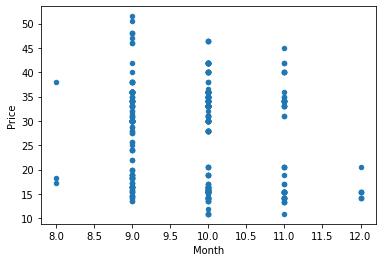

In [169]:
new_pumpkins.plot.scatter('Month','Price')

<AxesSubplot:xlabel='DayOfYear', ylabel='Price'>

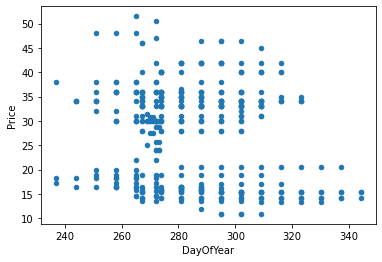

In [170]:
new_pumpkins.plot.scatter('DayOfYear','Price')

In [171]:
print(new_pumpkins['Month'].corr(new_pumpkins['Price']))
print(new_pumpkins['DayOfYear'].corr(new_pumpkins['Price']))

-0.14878293554077535
-0.16673322492745407


Úgy tűnik, hogy a korreláció elég kicsi, de van valami más, fontosabb kapcsolat – mert a fenti ábrán az árpontok több különálló klasztert alkotnak. Készítsünk egy ábrát, amely megmutatja a különböző tökfajtákat:


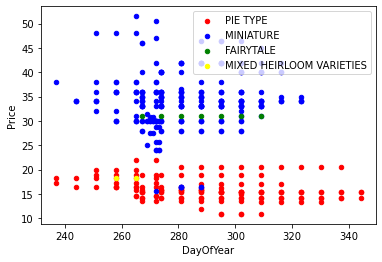

In [172]:
ax=None
colors = ['red','blue','green','yellow']
for i,var in enumerate(new_pumpkins['Variety'].unique()):
    ax = new_pumpkins[new_pumpkins['Variety']==var].plot.scatter('DayOfYear','Price',ax=ax,c=colors[i],label=var)

<AxesSubplot:xlabel='Variety'>

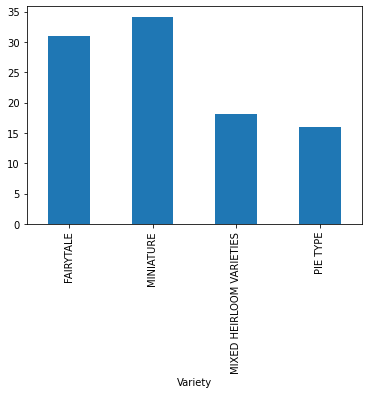

In [173]:
new_pumpkins.groupby('Variety')['Price'].mean().plot(kind='bar')

-0.2669192282197318


<AxesSubplot:xlabel='DayOfYear', ylabel='Price'>

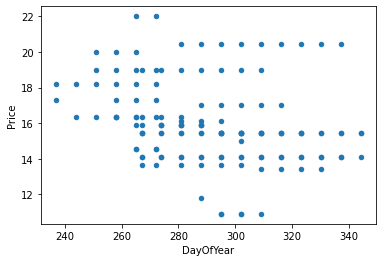

In [174]:
pie_pumpkins = new_pumpkins[new_pumpkins['Variety']=='PIE TYPE']
print(pie_pumpkins['DayOfYear'].corr(pie_pumpkins['Price']))
pie_pumpkins.plot.scatter('DayOfYear','Price')

### Lineáris regresszió

A Scikit Learn könyvtárat fogjuk használni lineáris regressziós modell betanításához:


In [175]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

In [176]:
X = pie_pumpkins['DayOfYear'].to_numpy().reshape(-1,1)
y = pie_pumpkins['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

pred = lin_reg.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')


Mean error: 2.77 (17.2%)


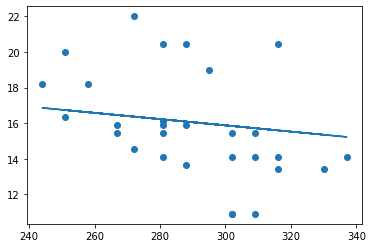

In [177]:
plt.scatter(X_test,y_test)
plt.plot(X_test,pred)

A vonal meredeksége meghatározható a lineáris regresszió együtthatóiból:


In [178]:
lin_reg.coef_, lin_reg.intercept_

(array([-0.01751876]), 21.133734359909326)

Használhatjuk a betanított modellt az ár előrejelzésére:


In [179]:
# Pumpkin price on programmer's day

lin_reg.predict([[256]])

array([16.64893156])

### Polinomiális regresszió

Néha a jellemzők és az eredmények közötti kapcsolat eleve nem lineáris. Például a tök ára télen (hónapok=1,2) magas lehet, majd nyáron (hónapok=5-7) csökken, és utána ismét emelkedik. A lineáris regresszió nem képes pontosan megragadni ezt a kapcsolatot.

Ilyen esetben érdemes lehet további jellemzőket hozzáadni. Egy egyszerű módszer az, hogy az input jellemzőkből polinomokat használunk, ami **polinomiális regressziót** eredményez. A Scikit Learn-ben automatikusan előre kiszámíthatjuk a polinomiális jellemzőket pipeline-ok segítségével:


Mean error: 2.73 (17.0%)
Model determination:  0.07639977655280217


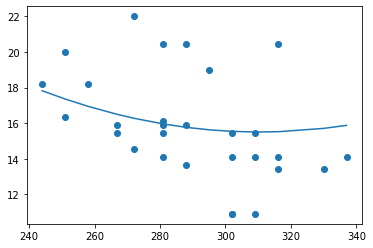

In [180]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())

pipeline.fit(X_train,y_train)

pred = pipeline.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

score = pipeline.score(X_train,y_train)
print('Model determination: ', score)

plt.scatter(X_test,y_test)
plt.plot(sorted(X_test),pipeline.predict(sorted(X_test)))

### Különböző kódolási módok

Ideális esetben szeretnénk ugyanazzal a modellel előre jelezni az árakat különböző tök fajták esetében. Ahhoz, hogy figyelembe vegyük a fajtát, először numerikus formára kell átalakítanunk, vagyis **kódolnunk**. Erre több módszer is létezik:

* Egyszerű numerikus kódolás, amely egy táblázatot készít a különböző fajtákról, majd a fajta nevét lecseréli a táblázatban szereplő indexre. Ez nem a legjobb megoldás lineáris regresszióhoz, mivel a lineáris regresszió figyelembe veszi az index numerikus értékét, és az index numerikus értéke valószínűleg nem áll összefüggésben az árral.
* Egy-hot kódolás, amely a `Variety` oszlopot négy külön oszlopra cseréli, egyet minden fajtának. Ezek az oszlopok 1-et tartalmaznak, ha az adott sor az adott fajtához tartozik, és 0-t, ha nem.

Az alábbi kód megmutatja, hogyan tudunk egy fajtát egy-hot kódolással átalakítani:


In [181]:
pd.get_dummies(new_pumpkins['Variety'])

FAIRYTALE  MINIATURE  MIXED HEIRLOOM VARIETIES  PIE TYPE
70            0          0                         0         1
71            0          0                         0         1
72            0          0                         0         1
73            0          0                         0         1
74            0          0                         0         1
...         ...        ...                       ...       ...
1738          0          1                         0         0
1739          0          1                         0         0
1740          0          1                         0         0
1741          0          1                         0         0
1742          0          1                         0         0

[415 rows x 4 columns]

### Lineáris regresszió fajták alapján

Most ugyanazt a kódot fogjuk használni, mint korábban, de a `DayOfYear` helyett az egy-hot-kódolt fajtát fogjuk bemenetként használni:


In [182]:
X = pd.get_dummies(new_pumpkins['Variety'])
y = new_pumpkins['Price']

In [183]:
def run_linear_regression(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    lin_reg = LinearRegression()
    lin_reg.fit(X_train,y_train)

    pred = lin_reg.predict(X_test)

    mse = np.sqrt(mean_squared_error(y_test,pred))
    print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

    score = lin_reg.score(X_train,y_train)
    print('Model determination: ', score)

run_linear_regression(X,y)

Mean error: 5.24 (19.7%)
Model determination:  0.774085281105197


Megpróbálhatjuk ugyanígy használni más jellemzőket is, és kombinálhatjuk őket numerikus jellemzőkkel, mint például a `Month` vagy a `DayOfYear`:


In [184]:
X = pd.get_dummies(new_pumpkins['Variety']) \
        .join(new_pumpkins['Month']) \
        .join(pd.get_dummies(new_pumpkins['City'])) \
        .join(pd.get_dummies(new_pumpkins['Package']))
y = new_pumpkins['Price']

run_linear_regression(X,y)

Mean error: 2.84 (10.5%)
Model determination:  0.9401096672643048


### Polinomiális regresszió

A polinomiális regresszió használható egy-hot-kódolt kategóriális jellemzőkkel is. A polinomiális regresszió betanításához szükséges kód lényegében ugyanaz lenne, mint amit fentebb láttunk.


In [185]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

pipeline.fit(X_train,y_train)

pred = pipeline.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

score = pipeline.score(X_train,y_train)
print('Model determination: ', score)

Mean error: 2.23 (8.25%)
Model determination:  0.9652870784724543



---

**Felelősségkizárás**:  
Ez a dokumentum az [Co-op Translator](https://github.com/Azure/co-op-translator) AI fordítási szolgáltatás segítségével lett lefordítva. Bár törekszünk a pontosságra, kérjük, vegye figyelembe, hogy az automatikus fordítások hibákat vagy pontatlanságokat tartalmazhatnak. Az eredeti dokumentum az eredeti nyelvén tekintendő hiteles forrásnak. Kritikus információk esetén javasolt professzionális, emberi fordítást igénybe venni. Nem vállalunk felelősséget a fordítás használatából eredő félreértésekért vagy téves értelmezésekért.
